In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Загружаю данные
df = pd.read_csv(r"C:\Users\silen\OneDrive\Рабочий стол\учеба\СОИ\пр2\17100135-eng\17100135.csv")

# Фильтрую: 2022 год, оба пола, все возраста, убираем "Canada" и общие строки
df_filtered = df[
    (df["REF_DATE"] == 2022) &
    (df["Sex"] == "Both sexes") &
    (df["Age group"] == "All ages") &
    (~df["GEO"].str.contains("Canada"))
].copy()

# Оставляю нужное
df_clean = df_filtered[["GEO", "VALUE"]].reset_index(drop=True)
df_clean = df_clean.dropna()  # на всякий случай

# Создаём группировку
large_cmas = ["Toronto (CMA), Ontario", "Montréal (CMA), Quebec", "Vancouver (CMA), British Columbia",
              "Calgary (CMA), Alberta", "Ottawa - Gatineau (CMA), Ontario/Quebec", "Edmonton (CMA), Alberta"]

def classify_region(geo):
    if any(city in geo for city in large_cmas):
        return "Large CMA (≥1M)"
    elif "(CMA)" in geo:
        return "Medium/Small CMA"
    else:
        return "Non-CMA (rural/small towns)"

df_clean["Group"] = df_clean["GEO"].apply(classify_region)

print(df_clean["Group"].value_counts())
print("\nПервые строки:")
print(df_clean.head(10))
print("\nПоследние строки:")
print(df_clean.tail(10))

Group
Non-CMA (rural/small towns)    136
Medium/Small CMA                31
Large CMA (≥1M)                  6
Name: count, dtype: int64

Первые строки:
                                           GEO      VALUE             Group
0  St. John's (CMA), Newfoundland and Labrador   219119.0  Medium/Small CMA
1                   Halifax (CMA), Nova Scotia   480582.0  Medium/Small CMA
2                 Moncton (CMA), New Brunswick   171608.0  Medium/Small CMA
3              Saint John (CMA), New Brunswick   135622.0  Medium/Small CMA
4                       Saguenay (CMA), Quebec   165185.0  Medium/Small CMA
5                         Québec (CMA), Quebec   848776.0  Medium/Small CMA
6                     Sherbrooke (CMA), Quebec   231055.0  Medium/Small CMA
7                 Trois-Rivières (CMA), Quebec   167732.0  Medium/Small CMA
8                       Montréal (CMA), Quebec  4378796.0   Large CMA (≥1M)
9      Ottawa - Gatineau (CMA), Ontario/Quebec  1498610.0   Large CMA (≥1M)

Последние 

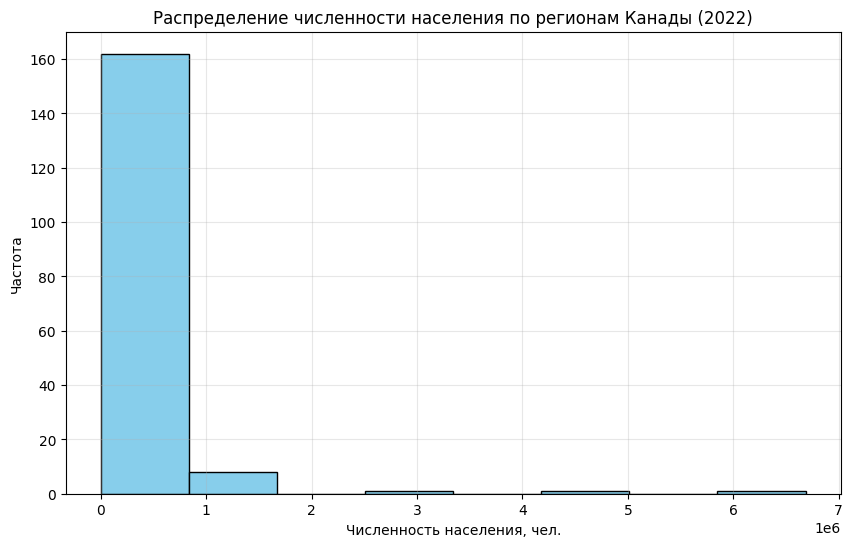

In [24]:
plt.figure(figsize=(10,6))
plt.hist(df_clean['VALUE'], bins=8, edgecolor='black', color='#87CEEB')
plt.title('Распределение численности населения по регионам Канады (2022)')
plt.xlabel('Численность населения, чел.')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

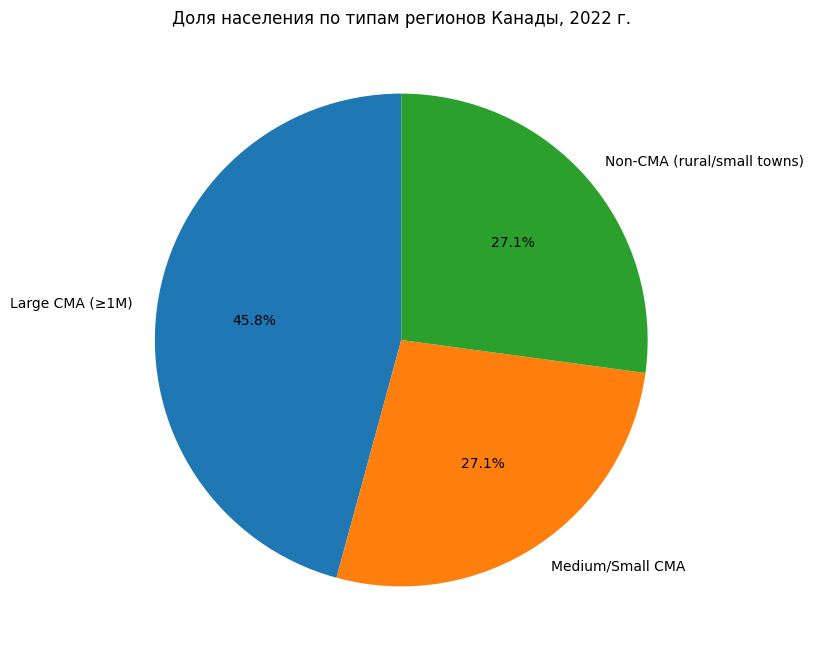

In [25]:
pop_by_group = df_clean.groupby('Group')['VALUE'].sum()
plt.figure(figsize=(8,8))
plt.pie(pop_by_group, labels=pop_by_group.index, autopct='%1.1f%%', startangle=90)
plt.title('Доля населения по типам регионов Канады, 2022 г.')
plt.show()

**1.4.1. Критерий проверки равенства математических ожиданий двух независимых совокупностей большого объёма (Z-критерий)**

In [36]:
# убедимся, что df_clean существует и Group правильно создан
print("Проверка групп:")
print(df_clean['Group'].value_counts())
print("Всего строк:", len(df_clean))

cma_data = df_clean[df_clean['Group'] != 'Non-CMA (rural/small towns)']['VALUE']
non_cma_data = df_clean[df_clean['Group'] == 'Non-CMA (rural/small towns)']['VALUE']

print(f"\nCMA регионов: {len(cma_data)}")
print(f"Non-CMA регионов: {len(non_cma_data)}")

# Если где-то 0 — сразу увидим
if len(cma_data) == 0 or len(non_cma_data) == 0:
    raise ValueError("Одна из групп пустая! Проверь классификацию.")

# Подсчет
x_mean = cma_data.mean(); y_mean = non_cma_data.mean()
s1_2 = cma_data.var(ddof=1); s2_2 = non_cma_data.var(ddof=1)
n1, n2 = len(cma_data), len(non_cma_data)



print(f"\nСреднее по CMA: {x_mean:,.0f}")
print(f"Среднее по Non-CMA: {y_mean:,.0f}")
print(f"Дисперсия CMA: {s1_2:,.0f}")
print(f"Дисперсия Non-CMA: {s2_2:,.0f}")

# Стандартная ошибка
se = np.sqrt(s1_2/n1 + s2_2/n2)
z = stats.norm.ppf(0.975)
lower = x_mean - y_mean - z*se
upper = x_mean - y_mean + z*se

print(f"\n95% доверительный интервал для разности средних:")
print(f"Δ = ({lower:,.0f} ; {upper:,.0f})")

Проверка групп:
Group
Non-CMA (rural/small towns)    136
Medium/Small CMA                31
Large CMA (≥1M)                  6
Name: count, dtype: int64
Всего строк: 173

CMA регионов: 37
Non-CMA регионов: 136

Среднее по CMA: 797,439
Среднее по Non-CMA: 80,797
Дисперсия CMA: 1,709,390,960,822
Дисперсия Non-CMA: 42,990,956,087

95% доверительный интервал для разности средних:
Δ = (293,925 ; 1,139,357)


**1.4.2. Критерий корреляции Спирмена**

In [39]:
from scipy.stats import spearmanr

# Фильтруем 2021 и 2022 годы
df_2021 = df[(df["REF_DATE"] == 2021) & 
             (df["Sex"] == "Both sexes") & 
             (df["Age group"] == "All ages")][["GEO", "VALUE"]].rename(columns={"VALUE": "pop_2021"})

df_2022 = df[(df["REF_DATE"] == 2022) & 
             (df["Sex"] == "Both sexes") & 
             (df["Age group"] == "All ages")][["GEO", "VALUE"]].rename(columns={"VALUE": "pop_2022"})

# Объединяем по GEO
merged = pd.merge(df_2021, df_2022, on="GEO", how="inner")

# Убираем пропуски (если вдруг есть)
merged = merged.dropna()

print(f"Количество регионов с данными за оба года: {len(merged)}")

# Критерий Спирмена
rho, p_value = spearmanr(merged["pop_2021"], merged["pop_2022"])

print(f"ρ_s = {rho:.6f}")
print(f"p-value = {p_value:.2e}")

Количество регионов с данными за оба года: 178
ρ_s = 0.999823
p-value = 1.01e-305


**1.4.3. Критерий Манна–Уитни (U-тест)**

In [40]:
from scipy.stats import mannwhitneyu

cma = df_clean[df_clean['Group'] != 'Non-CMA (rural/small towns)']['VALUE']
non_cma = df_clean[df_clean['Group'] == 'Non-CMA (rural/small towns)']['VALUE']

stat, p = mannwhitneyu(cma, non_cma, alternative='two-sided')
print(f"U-статистика = {stat:,.0f}")
print(f"p-value = {p:.2e}")

U-статистика = 4,815
p-value = 1.75e-17


**1.4.4. Медианный критерий**

In [41]:
from scipy.stats import median_test

large  = df_clean[df_clean['Group'] == 'Large CMA (≥1M)']['VALUE']
medium = df_clean[df_clean['Group'] == 'Medium/Small CMA']['VALUE']
non    = df_clean[df_clean['Group'] == 'Non-CMA (rural/small towns)']['VALUE']
stat, p, med, tbl = median_test(large, medium, non)
print(f"χ² = {stat:.3f}, p-value = {p:.2e}")

χ² = 47.613, p-value = 4.58e-11


**2.2. Тест Андерсона–Дарлинга** 

In [43]:
from scipy.stats import anderson_ksamp

# Группы численности населения
large  = df_clean[df_clean['Group'] == 'Large CMA (≥1M)']['VALUE']
medium = df_clean[df_clean['Group'] == 'Medium/Small CMA']['VALUE']
non    = df_clean[df_clean['Group'] == 'Non-CMA (rural/small towns)']['VALUE']

# Тест Андерсона–Дарлинга для нескольких выборок
result = anderson_ksamp([large, medium, non])

print(f"Statistic = {result.statistic:.3f}")
print(f"Significance level (p-value) = {result.significance_level:.2e}")


Statistic = 44.510
Significance level (p-value) = 1.00e-03
